In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphviz

# Hidden Markov Model
## Application in Biological Sequence Analysis

### Abstract
Nothing beats experimental work when it comes to biological sciences and reliably determining the function or properties of a given biological object - be it a nucleic acid, protein or some other biological molecule. However with the evergrowing body of data that comes with sequencing genomes, the need for quicker and easier evaluation of that data presents itself.

For more than seventy years now the branch of biology called computational biology has been dealing with questions regarding the sequence and structure of biological molecules, extending increasingly to the analysis of their function in the 1990s. Developing computational methods that can infer biological information from sequence alone lies in the core of the field. As most of the problems are essentially statistical, many of the most powerful methods for analysis make use of probability theory.

Perhaps one of the most widely used probabilistic models in bioinformatics and computational biology is the hidden Markov model. It is most commonly applied to the analysis of DNA sequences - their classification or the detection of specific regions on them.

In this project I try to outline the basic definitions that constitute the hidden Markov model, as well as present some of the algorithms based on it that are used in biological sequence analysis. Finally I give some examples on how that would look like and work in Python code.

### Probabilities and Bayes' theorem
Let's consider having a biological sequence and more specifically a DNA sequence. It is a string of finite alphabet of residues which in this case are the four nucleotides A, T, G and C. Now assume that each residue $a$ occurs at random, independant of all the other residues in the sequence, with probability $q_a$. Following the rule of product, if the DNA sequence is denoted as $x_{1}...x_{n}$ the probability of the whole sequence is the product $q_{x_1}q_{x_2}...q_{x_n}=\prod_{i=1}^{n}q_{x_i}$.


#### Maximum likelihood estimation
The parameters for a probabilistic model are typically estimated from large sets of trusted examples, often called a _training set_. For example, the probability $q_a$ of a residue $a$ can be estimated as the observed frequency of residues in a database of known DNA sequences. This is called _maximum likelihood estimation_ (MLE). In general, given a model with parameters d and a set of data D, the maximum likelihood estimate for $\theta$ is that value which maximises $P(D|\theta)$.

A problem when estimating parameters for a model from a limited set of data is that the model becomes very well adapted to the training data but it fails to generalise well to new data. This process is called _overfitting_.


#### Conditional, joint and marginal probabilities
The probability for an event X to occur, given an event Y, is called _conditional probability_ of X given Y and is denoted as $P(X|Y)$. We can also write is as the probability of observing some data given a probability model, or $P(data|model)$.

The probability for an event X to occur together and at the same time with event Y is called _joint probability_ and is denoted as $P(X, Y)=P(X|Y)P(Y)$.

If conditional or joint probabilities are known, a _marginal probability_ can be calculated using $P(X)=\sum\limits_{Y}P(X, Y)=\sum\limits_{Y}P(X|Y)P(Y)$, where the sums are over all possible events Y.


#### Bayes' theorem
So far we can calculate what is the probability for some data to occur given some model. For example what is the probability to get a six rolling a fair dice. However sometimes what we want to find is the posterior (or inverse) probability - the probability that we have some model given some data that already occured, or $P(model|data)$. Using the dice example again, we want to find what is the probability of having an unfair dice (with 0.5 probability for six) if we got three sixes in a row.

The solution to the problem of finding posterior probabilities is the Bayes' theorem:

$$ P(X|Y) = \frac{P(Y|X)P(X)}{P(Y)} $$

In order to prevent a model overfitting if there isn't enough data available to reliably estimate parameters, we can use prior knowledge to constrain the estimates. Bayes' theorem can be used to calculate the posterior probability of any particular set of parameters $\theta$ given some data D. Since the parameters are usually continuous rather than discrete quantities, the theorem looks like this:

$$ P(\theta|D) = \frac{P(\theta)P(D|\theta)}{\int_{\theta^\prime}P(\theta^\prime)P(D|\theta^\prime)} $$

### Hidden Markov model
Having gathered some data and being presented with a single biological sequence, we might want to ask "Does this sequence belong to a particular family?" or "Assuming the sequence does come from some family, what can we say about its internal structure?". In other words, based on a sequence of symbols from some alphabet, we want to find what does the sequence represent. These types of questions can be answered using a very general form of prababilistic model for sequences of symbols, called a hidden Markov model (HMM) as well as the simpler Markov chain.

#### Markov chain
By definition a Markov chain is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. Graphically it is shown as a collection of states with arrows between them. In the case of DNA there is a state for each of the four nucleotides A, T, G, C and it looks like this:

<img src="Markov_chain.png" alt="Markov chain" />

A probability parameter, called _transition probability_ $a_{st}$, is associated with each arrow. It determines the probability of a certain residue following another residue, or one state following another state. The transition probability is defined as:

$$ a_{st} = P(x_i=t|x_{i-1}=s) $$

Key property of a Markov chain is that the probability of each symbol $x_i$ depends only on the value of the preceeding symbol $x_{i-1}$ and not on the entire previous sequence. That way, for any probabalistic model of sequences, the probability of the sequence can be written as:

$$ P(x) = P(x_L|x_{L-1})P(x_{L-1}|x_{L-2})...P(x_2|x_1)P(x_1) = P(x_1)\prod_{i=2}^{L}a_{x_{i-1}x_i} $$

In addition to the transition probabilities the probability of starting in a particular state $P(x_1)$ must also be given. Thus we can add an extra begin and end states. Those states can be treated as silent and just serve as start and end points.

The entire behaviour of a Markov chain can be described using a transition matrix. The dimension of a transition matrix is the number of states of the Markov chain, and all the elements describe the probability of moving from one state to another (or back to the same state). This means each row of the matrix is a probability vector, and the sum of its entries is 1.

#### Hidden Markov model
##### Through a biological example
To provide a better explanation to the model, I will present a really nice example used by Sean Eddy and published in _Nature Biotechnology_. It makes use of a splice site recognition problem so before moving on, let's have a quick introduction to the used biological terms. Very simply put a DNA sequence consists of two types of regions - coding and noncoding. The coding regions are called exons and the noncoding ones - introns. So in order to have the product, say protein, encoded by a given DNA sequence, the introns are removed. The "cut here" label in the sequence lies at the boundary of an exon and intron and is called a splice site.

Now let's assume we have a DNA sequence starting with an exon, containing a 5′ splice site and ending with an intron. The problem is to identify when one region switches to the other, or where the splice site is. To do that there must be different probabilites for each of the three types of sequences, meaning that the nucleotide composition of the three is in different proportion. As proposed in the paper, let's say that the exons have a unifrom base compostition on average (25% for each base), the introns are A/T rich (40% for each of the two and 10% for each of the other two bases - G and C), and the splice site is almost always a G (95% for G and 5% for A). This information allows us to draw a hidden Markov model which looks like this:

<img src="HMM_splice_site.png" alt="Hidden Markov model" />

The model contains three _states_ - one for each of the regions, which can be labeled E (exon), 5 (5′ splice site) and I (intron). Each state has its own _emission probabilities_ (shown above the states) which model the base compostion for the regions. Each state also has _transition probabilities_ (arrows) which are the probabilites of moving from on state to a new one.

Every time a state is visited a residue is emitted from the state's emission probability distribution. Then the next state is chosen according to the state's transition probability distribution. This way the model generates two strings of information. The first one is the underlying _state path_ denoted by the labels and the second one is the _observed sequence_ which is the generated DNA sequence. We are given only the observed sequence and so the underlying state path is hidden. More specifically it is a hidden Markov chain, hence the name of the model being _hidden_ Markov model.

##### Back to mathematical notations
The state sequence, or the state path, is denoted as $\pi$ and is characterised by parameters:

$$ a_{kl} = P(\pi_i=l|\pi_{i-1}=k) $$

This is the transition probability from state $k$ to state $l$.

On the other hand, the emission probability of the symbol $b$ to emit from a state $k$ is defined as:

$$ e_k(b) = P(x_i=b|\pi_i=k) $$

Generating an observable sequence with HMM follows the steps described in the biological example. In a more mathematical sense first a state $\pi_1$ is chosen according to the transition probabilites $a_{0i}$. While in that state, an observation is emitted according to the emission probability $e_{\pi_1}$ for that state. Afterwards a new state $\pi_2$ is chosen according to the transition probabilites $a_{{\pi_1}i}$ and so on. This leads us to the joint probability of an observed sequence $x$ and a state path $\pi$ which is written as:

$$ P(x,\pi) = a_{0\pi_1}\prod_{i=1}^{L}e_{\pi_i}(x_i)a_{\pi_{i}\pi_{i+1}} $$

In practice however this equation is not really useful since in general we don't know the hidden state path. It is actually precisely that path that we want to infer. There are potentially many state paths that could generate the same sequence and on some occasions we want to find the one with the highest probability.

### Dynamic programming algorithms for state path estimation
#### The Viterbi algorithm
To find out what the observation sequence means by considering the underlying states is called _decoding_. One of the most common approaches to decoding is the Viterbi algorithm which is used to find the most probable state path.

If we go back to the biological example from before and look at the DNA sequence we can see that there are 14 possible paths with non-zero probabibility, since there are 14 internal As and Gs which the splice site could be on. On the figure are shown the six most probable paths corresponding to the six Gs in the sequence. So how do we calculate that probability and which one should we choose?

The path with the highest probability is denoted as:

$$ \pi^* = \underset{\pi}{\operatorname{argmax}}P(x,\pi)$$

It can be found recursively. If we know the probability $v_k(i)$ of the most probable path ending in state $k$ with observation $i$ for all the states $k$, then these probabilites can be calculated for observation $x_{i+1}$ as:

$$ v_l(i+1) = e_l(x_{i+1})\max_{k}(v_k(i)a_{kl}) $$

All sequences have to start in the begin state, or state 0, and so the initional condition is that $v_0(0)=1$.

The full Viterbi algorithm looks like this:

__Algorithm: Viterbi__

Initialisation $(i=0)$:

$$ v_0(0)=1, v_k(0) = 0 for k > 0 $$

Recursion $(i=1...L)$:

$$ v_l(i)=e_l(x_i)\max_{k}(v_k(i-1)a_{kl})$$
$$ ptr_i(l)=\underset{k}{\operatorname{argmax}}(v_k(i-1)a_{kl}) $$

Termination:

$$ P(x,\pi^*) = \max_{k}(v_k(L)a_{k0}) $$
$$ \pi_{L}^* = \underset{k}{\operatorname{argmax}}(v_k(L)a_{k0}) $$

Traceback $(i=L...1)$:

$$ \pi_{i-1}^* = ptr_i(\pi_i^*) $$

The most serious practical problem when using the Viterbi algorithm is that multiplying many probabilities yields very small numbers which leads to an underflow error. To resolve that issue the algorithm should always be done in log space - $\log(v_l(i))$, which will make the products become sums and the numbers stay reasonable.

Going again back to our example we can see the log probabilites of each of the six state paths on their right. The best path has a score of -41.22, which infers that the most likely splice site position is at the fifth G residue.

#### The forward algorithm
Looking at the scores of the states paths, there is an alternative path which differs very slightly in its log probability value from the highest-scoring one. We have -41.71 for the splice site to be at the sixth G position and -41.22 for it to be at the fifth. How confident are we that the fifth G is the right choice?

Many different paths can give rise to the same sequence $x$. Therefore in order to obtain the full probability of $x$ we must add the probabilites for all possible paths:

$$ P(x) = \sum_{\pi}P(x,\pi) $$

As it turns out, the full probability can be calculated with an algorithm similar to the Viterbi in which the maximisation steps are replaced with sums. It is called the _forward_ algorithm. The quantity corresponding to the Viterbi variable $v_k(i)$ in this algorithm is $f_k(i)$. This is the probability of the observed sequence up to and including $x_i$, requiring that $\pi_i = k$:

$$ f_k(i) = P(x_1...x_i, \pi_i=k) $$

The recursion equation is:

$$ f_l(i+1) = e_l(x_{i+1})\sum_{k}f_k(i)a_{kl} $$

The full forward algorithm looks like this:

__Algorithm: Forward__

Initialisation $(i=0)$:

$$ f_0(0)=1, f_k(0) = 0 for k > 0 $$

Recursion $(i=1...L)$:

$$ f_l(i)=e_l(x_i)\sum_{k}f_k(i-1)a_{kl}$$

Termination:

$$ P(x) = \sum_{k}f_k(L)a_{k0} $$

#### The backward algorithm
With the Viterbi algorithm we can find the most probable path through the model. However sometimes we might want to know for example what is the most probable state for an observation $x_i$. Or what is the probability that observation $x_i$ came from state $k$ given the observed sequence - $P(\pi_i=k|x)$. This is the posterior probability of state $k$ at time $i$ when the emitted sequence is known. In order to find this probability, first we have to calculate the probability of producing the entire observed sequence with the $i$th symbol being produced by state $k$:

$$ P(x,\pi_i=k) = P(x_1...x_i, \pi_i=k)P(x_{i+1}...x_L|\pi_i=k) $$

We already know the first term in the equation - this is the variable $f_k(i)$. The second one is called $b_k(i)$. It is analogous to the forward variable, but it is obtained by a backward recursion starting at the end of the sequence:

$$ b_k(i) = P(x_{i+1}...x_L|\pi_i=k) $$

The full backward algorithm looks like this:

__Algorithm: Backward__

Initialisation $(i=L)$:

$$ b_k(L) = a_{k0} for all k $$

Recursion $(i=L-1...1)$:

$$ b_k(i) = \sum_{l}a_{kl}e_l(x_{i+1})b_l(i+1) $$

Termination:

$$ P(x) = \sum_{l}a_{0l}e_l(x_1)b_l(1) $$

The probability of producing the entire observed sequence with the $i$th symbol being produced by state $k$ can now be written as:

$$ P(x,\pi_i=k) = f_k(i)b_k(i) $$

From this equation we can obtain the posterior probabilities:

$$ P(\pi_i=k|x) = \frac{f_k(i)b_k(i)}{P(x)}, $$

where $P(x)$ is the result of the forward (or backward) calculation.

Visiting one last time our splice site example we can see that by using posterior decoding we can calculate the posibility of having the splice site at a particular position. And so we have a 28% probability for the sixth G position to be correct and 46% for the fifth. That way we can conclude that indeed the fifth position has the biggest probability to be the right one and hence the state path associated with it to be correct.

### Implementation in Python
All we have to do now is see how everything that was outlined so far would look like written in Python. To do that, let's try to recreate the example we already know so well. The following code is adapted from Brian Christopher's [blog post](http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017).

First we are going to start with setting our hidden states, which will be "Exon" for exon, "SS" for 5′ splice site and "Intron" for intron. We also want to add their initial probabilities or the probability that any of the three could be the starting state.

In [3]:
hidden_states = ["Exon", "SS", "Intron"]
initial_probabilities = [1.0, 0.0, 0.0]

OK, let's see a table of what we have.

In [4]:
hidden_state_space = pd.Series(initial_probabilities, index=hidden_states, name="Hidden states")
hidden_state_space

Exon      1.0
SS        0.0
Intron    0.0
Name: Hidden states, dtype: float64

Now we have to add the transition probabilities or the probability of any state following any other. And again we want to see a table of the result.

In [5]:
transition_probabilities_table = pd.DataFrame(columns=hidden_states, index=hidden_states)
transition_probabilities_table.loc[hidden_states[0]] = [0.9, 0.1, 0.0]
transition_probabilities_table.loc[hidden_states[1]] = [0.0, 0.0, 1.0]
transition_probabilities_table.loc[hidden_states[2]] = [0.0, 0.0, 1.0]

transition_probabilities_table

,Exon,SS,Intron
Exon,0.9,0.1,0
SS,0,0,1
Intron,0,0,1


This is what the transition matrix looks like:

In [6]:
transition_matrix = transition_probabilities_table.values
print(transition_matrix)

[[0.9 0.1 0.0]
 [0.0 0.0 1.0]
 [0.0 0.0 1.0]]


Moving on to the observable states. These are the four letters from the DNA alphabet - the bases A, C, G and T. The probability of having any one of them at a given state is called the emission probability, so we will add those as well and see what the values will look like in a table and as an emssion matrix.

In [7]:
observable_states = ["A", "C", "G", "T"]

In [8]:
emission_probabilities_table = pd.DataFrame(columns=observable_states, index=hidden_states)
emission_probabilities_table.loc[hidden_states[0]] = [0.25, 0.25, 0.25, 0.25]
emission_probabilities_table.loc[hidden_states[1]] = [0.05, 0.00, 0.95, 0.00]
emission_probabilities_table.loc[hidden_states[2]] = [0.40, 0.10, 0.10, 0.40]

emission_probabilities_table

,A,C,G,T
Exon,0.25,0.25,0.25,0.25
SS,0.05,0,0.95,0
Intron,0.4,0.1,0.1,0.4


In [9]:
emission_matrix = emission_probabilities_table.values
print(emission_matrix)

[[0.25 0.25 0.25 0.25]
 [0.05 0.0 0.95 0.0]
 [0.4 0.1 0.1 0.4]]


Let's try to visualize the model. We will use the Networkx package to draw a graph with all the states and their transition and emission probabilities. As described by Brian, Networkx creates graphs that consist of nodes and edges. Nodes represent states, edges represent the lines connecting the nodes and have weights, which are the probabilities.

First we have to create the edges.

In [10]:
def get_graph_edges(probabilites_table):
    edges = {}
    for idx in probabilites_table.index:
        for col in probabilites_table.columns:
            edges[(idx, col)] = probabilites_table.loc[idx, col]
    return edges

In [11]:
hidden_edges_weights = get_graph_edges(transition_probabilities_table)
hidden_edges_weights

{('Exon', 'Exon'): 0.9,
 ('Exon', 'SS'): 0.1,
 ('Exon', 'Intron'): 0.0,
 ('SS', 'Exon'): 0.0,
 ('SS', 'SS'): 0.0,
 ('SS', 'Intron'): 1.0,
 ('Intron', 'Exon'): 0.0,
 ('Intron', 'SS'): 0.0,
 ('Intron', 'Intron'): 1.0}

In [12]:
observed_edges_weights = get_graph_edges(emission_probabilities_table)
observed_edges_weights

{('Exon', 'A'): 0.25,
 ('Exon', 'C'): 0.25,
 ('Exon', 'G'): 0.25,
 ('Exon', 'T'): 0.25,
 ('SS', 'A'): 0.05,
 ('SS', 'C'): 0.0,
 ('SS', 'G'): 0.95,
 ('SS', 'T'): 0.0,
 ('Intron', 'A'): 0.4,
 ('Intron', 'C'): 0.1,
 ('Intron', 'G'): 0.1,
 ('Intron', 'T'): 0.4}

Now we write a function that creates a graph, adds the nodes and edges to it (`add_edges_in_graph`) and finally draws it (`draw_graph`).

In [13]:
def add_edges_in_graph(graph, edges_weights):
    for states, p in edges_weights.items():
        origin, destination = states[0], states[1]
        graph.add_edge(origin, destination, weight=p, label=p)
    return graph

In [14]:
def draw_graph(hidden_states, hidden_edges, observed_edges):
    # Creating a graph object
    graph = nx.MultiDiGraph()
    
    # Setting nodes from the states
    graph.add_nodes_from(hidden_states)
    # Setting edges with weights from the transition and emission probabilities
    graph = add_edges_in_graph(graph, hidden_edges)
    graph = add_edges_in_graph(graph, observed_edges)
    
    # Setting the graph size so it is big and visible
    plt.figure(figsize=(12, 12))
    
    # Setting position and drawing the graph
    pos = nx.drawing.nx_pydot.graphviz_layout(graph, prog="neato")
    nx.draw_networkx(graph, pos, node_size=1500, node_color="red", arrowsize=15)
    
    # Adding labels to the graph
    edge_labels = {(n1,n2):d['label'] for n1,n2,d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    # Creating a dot file for a second visualization
    nx.drawing.nx_pydot.write_dot(graph, 'splice_site_markov.dot')

Let's see what our graph looks like:

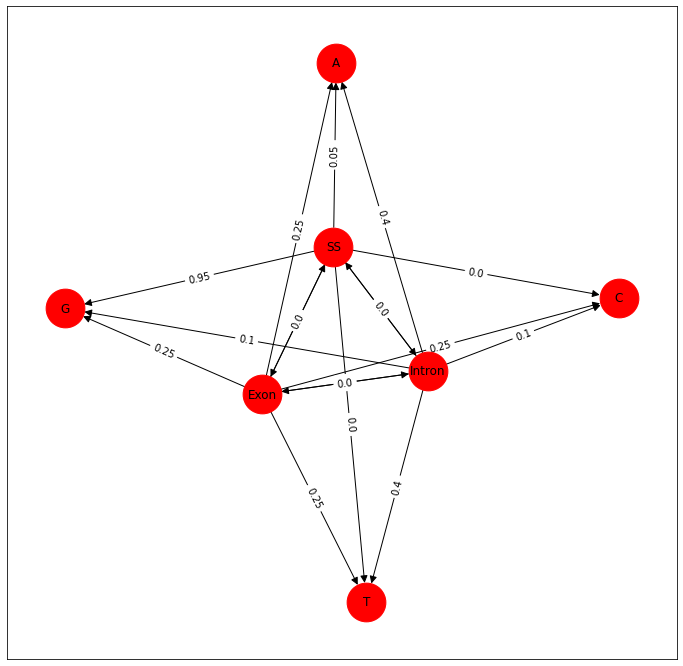

In [15]:
draw_graph(hidden_states, hidden_edges_weights, observed_edges_weights)

In the `draw_graph` function we create a dot file in the end. It is supposed to give us a more pleasing outlook of the graph, so let's have a look:

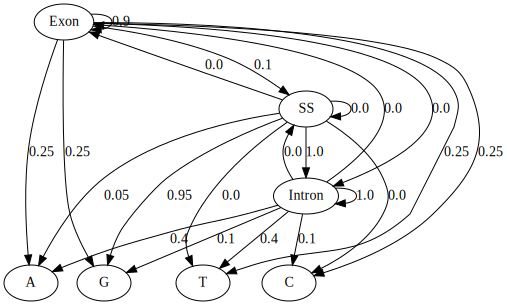

In [16]:
with open('splice_site_markov.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

With that we have our hidden Markov model set. What's next is generating a sequence of observable states which in our case is a DNA sequence. Here I will use the one shown in the example so that we can easily compare the result - CTTCATGTGAAAGCAGACGTAAGTCA.

The question now is what is the underlying states path that led to the generation of that sequence? As we already now there are many possible paths resulting in the same outcome we see. But we want to find the most probable one. For that we can use the Viterbi algorithm.
Let's write a function that implements it.

In [17]:
def viterbi(initial_probabilities, transition_probabilities, emission_probabilities, observed_seq):
    # Getting the number of hidden states and the total number of states in the observed sequence
    num_states = np.shape(emission_probabilities)[0]
    times = np.shape(observed_seq)[0]
    
    # Initializing blank arrays for the states path, the highest probabilities and argmax
    path = np.zeros(times)
    delta = np.zeros((num_states, times))
    phi = np.zeros((num_states, times))

    # Initialization step
    delta[:, 0] = initial_probabilities * emission_probabilities[:, observed_seq[0]]
    phi[:, 0] = 0

    # Recursion step
    for t in range(1, times):
        for s in range(num_states):
            delta[s, t] = np.max(delta[:, t-1] * transition_probabilities[:, s]) * emission_probabilities[s, observed_seq[t]]
            phi[s, t] = np.argmax(delta[:, t-1] * transition_probabilities[:, s])

    path[times-1] = np.argmax(delta[:, times-1])

    # Traceback step
    for t in range(times-2, -1, -1):
        path[t] = phi[int(path[t+1]), [int(i) for i in [t+1]]]

    return path, delta, phi

Since we are working with ndarrays we have to convert the observed sequence to integers before passing it as an argument to the function. We will also need to convert the generated from the algorithm path to a string of symbols for each of the hidden states. That's why now we are going to create a simple converting function.

In [18]:
def convert_states(mapper, states_sequnce):
    return [mapper[el] for el in states_sequnce]

In [19]:
observed_mapper = {"A": 0, "C": 1, "G": 2, "T": 3}
hidden_mapper = {0: "E", 1: "5", 2: "I"}

In [20]:
observed_sequence = list("CTTCATGTGAAAGCAGACGTAAGTCA")

In [21]:
observed_sequence_mapped = convert_states(observed_mapper, observed_sequence)
observed_sequence_mapped

[1, 3, 3, 1, 0, 3, 2, 3, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 3, 0, 0, 2, 3, 1, 0]

In [22]:
states_path, highest_probabilites, argmax_values = viterbi(initial_probabilities, transition_matrix, emission_matrix, observed_sequence_mapped)

We have our most probable states path. Let's convert it to its corresponding symbols and see if it matches the one from the example.

In [23]:
states_path_mapped = ''.join(convert_states(hidden_mapper, states_path))
expected_path = "EEEEEEEEEEEEEEEEEE5IIIIIII"

Moment of truth...

In [24]:
states_path_mapped == expected_path

True

We can also see the highest probability for each base to have been emitted from each of the three states:

In [25]:
highest_probabilites

array([[2.50000000e-01, 5.62500000e-02, 1.26562500e-02, 2.84765625e-03,
        6.40722656e-04, 1.44162598e-04, 3.24365845e-05, 7.29823151e-06,
        1.64210209e-06, 3.69472970e-07, 8.31314183e-08, 1.87045691e-08,
        4.20852805e-09, 9.46918811e-10, 2.13056732e-10, 4.79377648e-11,
        1.07859971e-11, 2.42684934e-12, 5.46041102e-13, 1.22859248e-13,
        2.76433308e-14, 6.21974943e-15, 1.39944362e-15, 3.14874815e-16,
        7.08468334e-17, 1.59405375e-17],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.42382813e-05, 0.00000000e+00, 1.36954468e-05, 0.00000000e+00,
        6.93331993e-07, 8.21051044e-09, 1.84736485e-09, 4.15657091e-10,
        1.77693407e-09, 0.00000000e+00, 4.73459406e-12, 2.02403896e-11,
        2.39688824e-13, 0.00000000e+00, 2.30550688e-13, 0.00000000e+00,
        6.14296240e-16, 1.38216654e-16, 5.90876196e-16, 0.00000000e+00,
        0.00000000e+00, 3.54234167e-19],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00

And the argmax values by time step for each state:

In [26]:
argmax_values

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2.,
        1., 2., 2., 1., 2., 2., 2., 2., 2., 2.]])

By the looks of it the Viterbi algorithm works correctly with the DNA sequence from the example. Now let's create our own hidden Markov model simulator. Based on the probabilities from earlier, this function will return a DNA sequence as well as a states sequence. In the end we will again test the Viterbi algorithm with the newly generated DNA sequence against the simulated states path. The code for the simulator is adapted from Huw A. Ogilvie from his [article](https://www.cs.rice.edu/~ogilvie/comp571/2018/09/20/hidden-markov-models.html).

In [27]:
def hmm_simulator(init_p, trans_p, emis_p):
    states_alphabet = 'E5I'
    bases_alphabet = 'ACGT'

    # The begin state is chosen according to the initial probability
    current_state = np.random.choice(3, p=init_p)
    # A base is emitted according to the emission probability of the state
    base = np.random.choice(4, p=list(emis_p[current_state]))

    # The corresponding symbols for the hidden and observed state are set
    simulated_states_sequence = states_alphabet[current_state]
    simulated_observed_sequence = bases_alphabet[base]

    # Generate a random number which represents the size of the generated sequences
    length = np.random.randint(20, 100)

    # Iterate through the chosen size and generate hidden and observed states
    for i in range(length):
        current_state = np.random.choice(3, p=list(trans_p[current_state]))
        base = np.random.choice(4, p=list(emis_p[current_state]))

        simulated_states_sequence += states_alphabet[current_state]
        simulated_observed_sequence += bases_alphabet[base]

    return simulated_states_sequence, simulated_observed_sequence

In [28]:
sim_states_seq, sim_observed_seq = hmm_simulator(initial_probabilities, transition_matrix, emission_matrix)

In [29]:
observed_sequence_mapped = convert_states(observed_mapper, sim_observed_seq)

In [30]:
states_path, highest_probabilites, argmax_values = viterbi(initial_probabilities, transition_matrix, emission_matrix, observed_sequence_mapped)

In [31]:
states_path_mapped = ''.join(convert_states(hidden_mapper, states_path))

In [32]:
print(f"Viterbi most probable path: {states_path_mapped}")
print(f"HMM simulated states path:  {sim_states_seq}")

Viterbi most probable path: EEEEE5IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
HMM simulated states path:  EEEEE5IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII


In [33]:
states_path_mapped == sim_states_seq

True

We saw that if we have already obtained the initial, transition and emission probabilities of the hidden and observed states, we can create a hidden Markov model that can generate observed sequences in that fashion. Based on such model, if we have a DNA sequence, we can find the most probable states path that emitted the sequence using the Viterbi algorithm.

### Conclusion
The advancement and availability in DNA sequence technologies in the past years have led to an enourmous amount of sequence data being gathered. The information that can be extraceted from those genomes can help better understand the different biological functions of molecules, cells and organisms. However to analyze all the available data would be nearly impossible without the help of computational methods.


In this project I tried to outline the basic concepts behind one such probabilistic model used widely in computational biology. That is the hidden Markov model which acts as a powerful tool in the heart of biological sequence analysis. There are many variations of the model and other models based on it that are used in different programs for gene finding, profile searches, multiple sequence alignment, regulatory site identification and many others. All those models provide a sound mathematical framework for modeling and analyzing biological sequences.

### References
1. Searls, David B.. _"Computational biology"_. Encyclopedia Britannica, 16 Nov. 2018, https://www.britannica.com/science/computational-biology. Accessed 27 May 2021.
2. Durbin R, Eddy S, Krogh A, Mitchison G. _Biological Sequence Analysis_. Cambridge, UK: Cambridge University Press; 1998. (free [pdf](http://www.mcb111.org/w06/durbin_book.pdf))
3. Eddy, S. _What is Bayesian statistics?_. Nat Biotechnol 22, 1177–1178 (2004). https://doi.org/10.1038/nbt0904-1177
4. Henry Maltby, Worranat Pakornrat, Jeremy Jackson,Adrian Hernandez, Christopher Williams, Calvin Lin, Jimin Khim, _Markov chains_, https://brilliant.org/wiki/markov-chains/
5. Eddy, S. _What is a hidden Markov model?_. Nat Biotechnol 22, 1315–1316 (2004). https://doi.org/10.1038/nbt1004-1315
6. Yoon BJ. _Hidden Markov Models and their Applications in Biological Sequence Analysis_. Curr Genomics. 2009;10(6):402-415. doi:10.2174/138920209789177575
7. Mattia Cinelli, _Hidden Markov Model for Biological Sequence_, https://towardsdatascience.com/hidden-markov-model-applied-to-biological-sequence-373d2b5a24c
8. Brian Christopher, _Introduction to Hidden Markov Models with Python Networkx and Sklearn_, http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017
9. Huw A. Ogilvie, _Hidden Markov models_, https://www.cs.rice.edu/~ogilvie/comp571/2018/09/20/hidden-markov-models.html